In [1]:
!git clone -b week9-dev https://github.com/vamsigp/EVA5/

Cloning into 'EVA5'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 417 (delta 9), reused 25 (delta 3), pack-reused 379
Receiving objects: 100% (417/417), 47.06 MiB | 35.88 MiB/s, done.
Resolving deltas: 100% (204/204), done.


In [2]:
%cd EVA5/trainer

/content/EVA5/trainer


In [3]:
!pip install -U albumentations

     |████████████████████████████████| 122kB 4.4MB/s 
     |████████████████████████████████| 952kB 8.5MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65165 sha256=df0961aa8d6012ab80cfef492f3f090856b1656799d7a99a85d16137da074b4f
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [4]:
%matplotlib inline

In [5]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from config import ModelConfig
from data_engine import DataEngine
from trainer import Trainer
from results import *
from utils import *

In [6]:
from Albumentations import *
from GradCAM import *

In [7]:
# from models.cifar10 import cifar10Model
from models.resnet import ResNet18

In [8]:
transform_album = album_compose()

In [9]:
# View model config
args = ModelConfig(transform_album)
args.print_config()

print()
# Set seed
init_seed(args)

Model Parameters:
{ 'batch_size_cpu': 64,
  'batch_size_cuda': 64,
  'dropout_value': 0.15,
  'epochs': 50,
  'num_workers': 4,
  'seed': 1,
  'train_transform': <Albumentations.album_compose object at 0x7f0b502b1ef0>}

CUDA Available


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane   dog  deer  deer


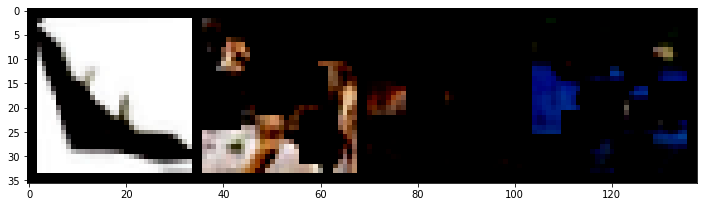

In [10]:
data = DataEngine(args)

# get some random training images
dataiter = iter(data.train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % data.classes[labels[j]] for j in range(4)))

In [12]:
device = which_device()
# model = Net(args).to(device)
model = ResNet18().to(device)
# model = cifar10Model().to(device)
show_model_summary(model, device, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [13]:
from torch.optim.lr_scheduler import StepLR,OneCycleLR

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
# scheduler = OneCycleLR(optimizer,max_lr=0.1,total_steps=20)

In [15]:
trainer = Trainer(model, 
                  device,
                  train_loader=data.train_loader, 
                  test_loader = data.test_loader, 
                  optimizer = optimizer, 
                  loss_func = criterion, 
                  lr_scheduler = scheduler) 

In [16]:
# (train_loss, train_acc, test_loss, test_acc) = trainer.train_model(epochs=args.epochs, lambda_l1=0.0001)
(train_loss, train_acc, test_loss, test_acc) = trainer.train_model(epochs=args.epochs, lambda_l1=0.0001)

  0%|          | 0/782 [00:00<?, ?it/s]

Current EPOCH: 0


Train set: Loss=11.403145790100098 Batch_id=781 Accuracy=40.54: 100%|██████████| 782/782 [01:08<00:00, 11.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 5066/10000 (50.66%)

Current EPOCH: 1


Train set: Loss=10.671150207519531 Batch_id=781 Accuracy=54.98: 100%|██████████| 782/782 [01:10<00:00, 11.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 5757/10000 (57.57%)

Current EPOCH: 2


Train set: Loss=9.561967849731445 Batch_id=781 Accuracy=62.02: 100%|██████████| 782/782 [01:10<00:00, 11.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0142, Accuracy: 6840/10000 (68.40%)

Current EPOCH: 3


Train set: Loss=8.516169548034668 Batch_id=781 Accuracy=67.23: 100%|██████████| 782/782 [01:10<00:00, 11.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0127, Accuracy: 7227/10000 (72.27%)

Current EPOCH: 4


Train set: Loss=8.005050659179688 Batch_id=781 Accuracy=69.93: 100%|██████████| 782/782 [01:11<00:00, 10.99it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0107, Accuracy: 7612/10000 (76.12%)

Current EPOCH: 5


Train set: Loss=6.985177516937256 Batch_id=781 Accuracy=72.37: 100%|██████████| 782/782 [01:10<00:00, 11.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0103, Accuracy: 7760/10000 (77.60%)

Current EPOCH: 6


Train set: Loss=6.258004665374756 Batch_id=781 Accuracy=74.27: 100%|██████████| 782/782 [01:10<00:00, 11.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0099, Accuracy: 7844/10000 (78.44%)

Current EPOCH: 7


Train set: Loss=5.9231743812561035 Batch_id=781 Accuracy=75.92: 100%|██████████| 782/782 [01:11<00:00, 11.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0105, Accuracy: 7715/10000 (77.15%)

Current EPOCH: 8


Train set: Loss=5.789444446563721 Batch_id=781 Accuracy=77.11: 100%|██████████| 782/782 [01:10<00:00, 11.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0093, Accuracy: 8014/10000 (80.14%)

Current EPOCH: 9


Train set: Loss=4.697293758392334 Batch_id=781 Accuracy=77.68: 100%|██████████| 782/782 [01:10<00:00, 11.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0085, Accuracy: 8149/10000 (81.49%)

Current EPOCH: 10


Train set: Loss=4.179931640625 Batch_id=781 Accuracy=78.42: 100%|██████████| 782/782 [01:10<00:00, 11.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0095, Accuracy: 7936/10000 (79.36%)

Current EPOCH: 11


Train set: Loss=3.909458637237549 Batch_id=781 Accuracy=79.01: 100%|██████████| 782/782 [01:10<00:00, 11.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0107, Accuracy: 7758/10000 (77.58%)

Current EPOCH: 12


Train set: Loss=3.572019100189209 Batch_id=781 Accuracy=79.34: 100%|██████████| 782/782 [01:10<00:00, 11.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0086, Accuracy: 8154/10000 (81.54%)

Current EPOCH: 13


Train set: Loss=3.3357551097869873 Batch_id=781 Accuracy=79.51: 100%|██████████| 782/782 [01:10<00:00, 11.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0092, Accuracy: 7994/10000 (79.94%)

Current EPOCH: 14


Train set: Loss=3.133227586746216 Batch_id=781 Accuracy=79.39: 100%|██████████| 782/782 [01:11<00:00, 11.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0091, Accuracy: 8014/10000 (80.14%)

Current EPOCH: 15


Train set: Loss=2.9838366508483887 Batch_id=781 Accuracy=79.69: 100%|██████████| 782/782 [01:10<00:00, 11.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0092, Accuracy: 8020/10000 (80.20%)

Current EPOCH: 16


Train set: Loss=2.5883936882019043 Batch_id=781 Accuracy=79.70: 100%|██████████| 782/782 [01:10<00:00, 11.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0090, Accuracy: 8075/10000 (80.75%)

Current EPOCH: 17


Train set: Loss=2.7765355110168457 Batch_id=781 Accuracy=79.92: 100%|██████████| 782/782 [01:10<00:00, 11.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0082, Accuracy: 8266/10000 (82.66%)

Current EPOCH: 18


Train set: Loss=2.620473623275757 Batch_id=781 Accuracy=79.86: 100%|██████████| 782/782 [01:10<00:00, 11.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0102, Accuracy: 7860/10000 (78.60%)

Current EPOCH: 19


Train set: Loss=2.580808401107788 Batch_id=781 Accuracy=80.01: 100%|██████████| 782/782 [01:10<00:00, 11.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0091, Accuracy: 8039/10000 (80.39%)

Current EPOCH: 20


Train set: Loss=2.519662380218506 Batch_id=781 Accuracy=80.50: 100%|██████████| 782/782 [01:10<00:00, 11.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0088, Accuracy: 8181/10000 (81.81%)

Current EPOCH: 21


Train set: Loss=2.190865993499756 Batch_id=781 Accuracy=80.16: 100%|██████████| 782/782 [01:10<00:00, 11.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0101, Accuracy: 7774/10000 (77.74%)

Current EPOCH: 22


Train set: Loss=2.1525039672851562 Batch_id=781 Accuracy=80.81: 100%|██████████| 782/782 [01:10<00:00, 11.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0103, Accuracy: 7853/10000 (78.53%)

Current EPOCH: 23


Train set: Loss=2.395415782928467 Batch_id=781 Accuracy=80.42: 100%|██████████| 782/782 [01:10<00:00, 11.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0084, Accuracy: 8219/10000 (82.19%)

Current EPOCH: 24


Train set: Loss=2.226616859436035 Batch_id=781 Accuracy=80.68: 100%|██████████| 782/782 [01:10<00:00, 11.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0098, Accuracy: 7895/10000 (78.95%)

Current EPOCH: 25


Train set: Loss=1.8612806797027588 Batch_id=781 Accuracy=80.76: 100%|██████████| 782/782 [01:10<00:00, 11.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0096, Accuracy: 7918/10000 (79.18%)

Current EPOCH: 26


Train set: Loss=2.610604763031006 Batch_id=781 Accuracy=80.97: 100%|██████████| 782/782 [01:10<00:00, 11.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0099, Accuracy: 7938/10000 (79.38%)

Current EPOCH: 27


Train set: Loss=1.7830023765563965 Batch_id=781 Accuracy=81.40: 100%|██████████| 782/782 [01:10<00:00, 11.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0085, Accuracy: 8215/10000 (82.15%)

Current EPOCH: 28


Train set: Loss=2.1584606170654297 Batch_id=781 Accuracy=81.27: 100%|██████████| 782/782 [01:10<00:00, 11.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0099, Accuracy: 7939/10000 (79.39%)

Current EPOCH: 29


Train set: Loss=2.3978190422058105 Batch_id=781 Accuracy=81.55: 100%|██████████| 782/782 [01:10<00:00, 11.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0080, Accuracy: 8261/10000 (82.61%)

Current EPOCH: 30


Train set: Loss=1.6872880458831787 Batch_id=781 Accuracy=81.47: 100%|██████████| 782/782 [01:11<00:00, 11.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0084, Accuracy: 8243/10000 (82.43%)

Current EPOCH: 31


Train set: Loss=1.4345836639404297 Batch_id=781 Accuracy=81.40: 100%|██████████| 782/782 [01:10<00:00, 11.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0072, Accuracy: 8414/10000 (84.14%)

Current EPOCH: 32


Train set: Loss=1.8139697313308716 Batch_id=781 Accuracy=81.83: 100%|██████████| 782/782 [01:10<00:00, 11.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0072, Accuracy: 8405/10000 (84.05%)

Current EPOCH: 33


Train set: Loss=2.065110206604004 Batch_id=781 Accuracy=81.90: 100%|██████████| 782/782 [01:10<00:00, 11.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0065, Accuracy: 8606/10000 (86.06%)

Current EPOCH: 34


Train set: Loss=1.8085929155349731 Batch_id=781 Accuracy=81.99: 100%|██████████| 782/782 [01:10<00:00, 11.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 8426/10000 (84.26%)

Current EPOCH: 35


Train set: Loss=1.582565426826477 Batch_id=781 Accuracy=82.19: 100%|██████████| 782/782 [01:11<00:00, 11.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 8431/10000 (84.31%)

Current EPOCH: 36


Train set: Loss=1.900787353515625 Batch_id=781 Accuracy=82.43: 100%|██████████| 782/782 [01:10<00:00, 11.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0082, Accuracy: 8317/10000 (83.17%)

Current EPOCH: 37


Train set: Loss=1.5215797424316406 Batch_id=781 Accuracy=82.30: 100%|██████████| 782/782 [01:10<00:00, 11.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0072, Accuracy: 8428/10000 (84.28%)

Current EPOCH: 38


Train set: Loss=1.5791261196136475 Batch_id=781 Accuracy=82.44: 100%|██████████| 782/782 [01:10<00:00, 11.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0076, Accuracy: 8372/10000 (83.72%)

Current EPOCH: 39


Train set: Loss=1.455928087234497 Batch_id=781 Accuracy=82.68: 100%|██████████| 782/782 [01:10<00:00, 11.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0073, Accuracy: 8439/10000 (84.39%)

Current EPOCH: 40


Train set: Loss=1.4994473457336426 Batch_id=781 Accuracy=82.95: 100%|██████████| 782/782 [01:11<00:00, 11.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0083, Accuracy: 8253/10000 (82.53%)

Current EPOCH: 41


Train set: Loss=1.9620835781097412 Batch_id=781 Accuracy=82.89: 100%|██████████| 782/782 [01:10<00:00, 11.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0082, Accuracy: 8214/10000 (82.14%)

Current EPOCH: 42


Train set: Loss=1.175015926361084 Batch_id=781 Accuracy=82.94: 100%|██████████| 782/782 [01:10<00:00, 11.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0090, Accuracy: 8073/10000 (80.73%)

Current EPOCH: 43


Train set: Loss=1.4702937602996826 Batch_id=781 Accuracy=82.94: 100%|██████████| 782/782 [01:10<00:00, 11.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0066, Accuracy: 8566/10000 (85.66%)

Current EPOCH: 44


Train set: Loss=1.2557815313339233 Batch_id=781 Accuracy=82.91: 100%|██████████| 782/782 [01:10<00:00, 11.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 8635/10000 (86.35%)

Current EPOCH: 45


Train set: Loss=1.6607283353805542 Batch_id=781 Accuracy=83.29: 100%|██████████| 782/782 [01:10<00:00, 11.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0065, Accuracy: 8634/10000 (86.34%)

Current EPOCH: 46


Train set: Loss=1.5844674110412598 Batch_id=781 Accuracy=83.44: 100%|██████████| 782/782 [01:11<00:00, 11.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0071, Accuracy: 8529/10000 (85.29%)

Current EPOCH: 47


Train set: Loss=1.5985608100891113 Batch_id=781 Accuracy=83.58: 100%|██████████| 782/782 [01:10<00:00, 11.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Accuracy: 8487/10000 (84.87%)

Current EPOCH: 48


Train set: Loss=2.0487964153289795 Batch_id=781 Accuracy=83.36: 100%|██████████| 782/782 [01:10<00:00, 11.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0065, Accuracy: 8572/10000 (85.72%)

Current EPOCH: 49


Train set: Loss=1.3637635707855225 Batch_id=781 Accuracy=83.68: 100%|██████████| 782/782 [01:10<00:00, 11.05it/s]



Test set: Average loss: 0.0073, Accuracy: 8469/10000 (84.69%)



In [17]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog',
			'frog', 'horse', 'ship', 'truck')

In [18]:
trainer.classwise_acc(classes)


Accuracy of plane : 80 %
Accuracy of   car : 94 %
Accuracy of  bird : 80 %
Accuracy of   cat : 69 %
Accuracy of  deer : 94 %
Accuracy of   dog : 63 %
Accuracy of  frog : 95 %
Accuracy of horse : 77 %
Accuracy of  ship : 90 %
Accuracy of truck : 96 %



In [19]:
misclassified_imgs = trainer.get_misclassified()

/content/EVA5/trainer/trainer.py:130: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  misclassified_inds = (is_correct == 0).nonzero()[:, 0]


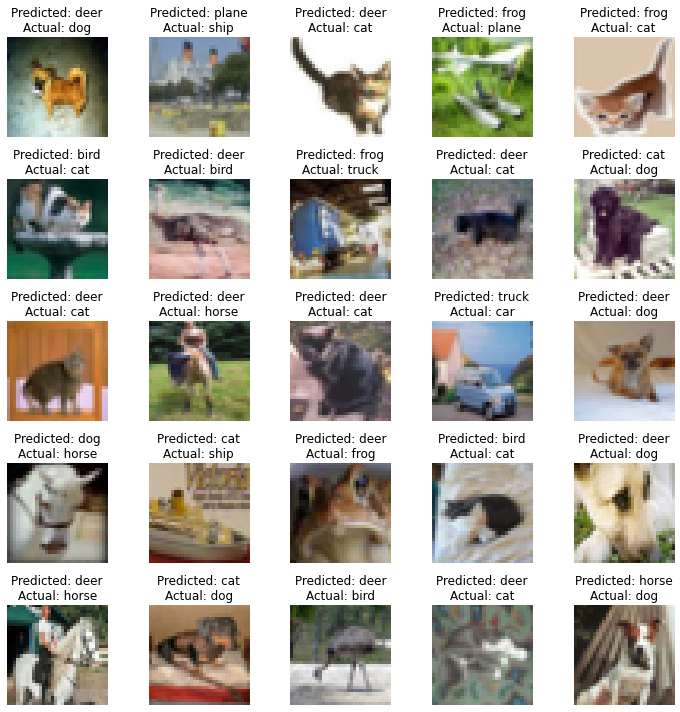

In [20]:
plot_misclassified_images(misclassified_imgs, classes, "misclassified_images1.png")

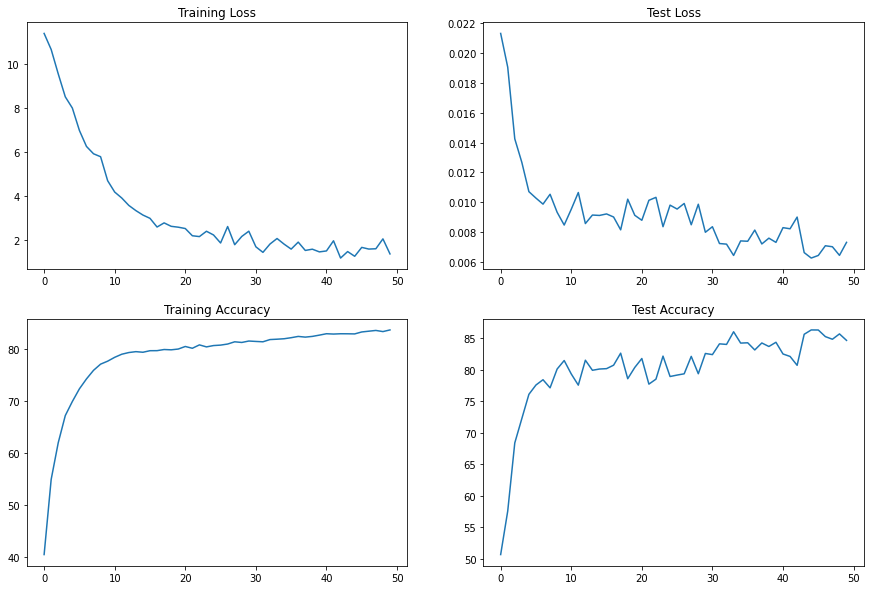

In [21]:
from results import plot_metrics
plot_metrics(train_loss, train_acc, test_loss, test_acc)

In [22]:
### GradCam

In [23]:
dataiter = iter(data.test_loader)
images, labels = dataiter.next()

In [24]:
import PIL
import numpy as np

In [25]:
# model.convblock

In [35]:
for name, layer in model.named_modules():
  if isinstance(layer, torch.nn.Conv2d):
    print(name, layer)

conv1 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer1.0.conv1 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer1.0.conv2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer1.1.conv1 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer1.1.conv2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer2.0.conv1 Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
layer2.0.conv2 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer2.0.shortcut.0 Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
layer2.1.conv1 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer2.1.conv2 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer3.0.conv1 Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), 

In [40]:
def plot_images_gradcam(torch_img,normed_torch_img, model):
    images=[]
    g1 = GradCAM(model, model.layer1)
    g2 = GradCAM(model, model.layer2)
    g3 = GradCAM(model, model.layer3)
    g4 = GradCAM(model, model.layer4)
    mask1, _ = g1(normed_torch_img)
    mask2, _ = g2(normed_torch_img)
    mask3, _ = g3(normed_torch_img)
    mask4, _ = g4(normed_torch_img)
    heatmap1, result1 = visualize_cam(mask1, torch_img)
    heatmap2, result2 = visualize_cam(mask2, torch_img)
    heatmap3, result3 = visualize_cam(mask3, torch_img)
    heatmap4, result4 = visualize_cam(mask4, torch_img)

    images.extend([torch_img.cpu(), heatmap1, heatmap2, heatmap3, heatmap4])
    images.extend([torch_img.cpu(), result1, result2, result3, result4])
    grid_image = make_grid(images, nrow=5)
    imshow(grid_image)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


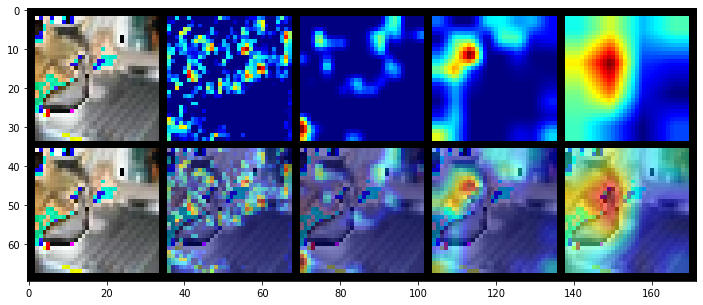

In [41]:
trans = transforms.ToPILImage()
pil_img=trans(torchvision.utils.make_grid(images[1]))
torch_img,normed_torch_img=change(pil_img,device)
plot_images_gradcam(torch_img,normed_torch_img, model)